# DNA Sequence Classification Model
This notebook builds a machine learning model to classify DNA sequences and predict disease risk

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

## Load Data

In [17]:
# Load the dataset
df = pd.read_csv('synthetic_dna_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nClass distribution:")
print(df['Class_Label'].value_counts())
print(f"\nDisease Risk distribution:")
print(df['Disease_Risk'].value_counts())

Dataset shape: (3000, 13)

First few rows:
  Sample_ID                                           Sequence  GC_Content  \
0  SAMPLE_1  CTTTCGGGATACTTTTGGGATGGTCTTGGTCAAGGGTTTTAGCCCG...        50.0   
1  SAMPLE_2  TTGACCAAATTTGATTGGAAGTGGTAAGCGCGTATTCCTAGCATCA...        45.0   
2  SAMPLE_3  GCGTGAGTTCTAATTTAAAAAGTCGTAACACGTACCCCGGCGTGTA...        51.0   
3  SAMPLE_4  ACTACGCGGACAAGAACCAACAGAACCTGGTTTTCGCAAGGGAGTG...        55.0   
4  SAMPLE_5  TTCAATGCAGATTGAAAGTTACTTTCATCTGCCCTATGGGTCCCTT...        46.0   

   AT_Content  Sequence_Length  Num_A  Num_T  Num_C  Num_G  kmer_3_freq  \
0        50.0              100     22     28     19     31        0.986   
1        55.0              100     27     28     22     23        0.486   
2        49.0              100     26     23     30     21        0.367   
3        45.0              100     28     17     23     32        0.404   
4        54.0              100     24     30     25     21        0.818   

   Mutation_Flag Class_Label Disease_

## Comprehensive Dataset Visualization

Checking actual columns in dataset:
Total columns: 13

First 10 columns: ['Sample_ID', 'Sequence', 'GC_Content', 'AT_Content', 'Sequence_Length', 'Num_A', 'Num_T', 'Num_C', 'Num_G', 'kmer_3_freq']

Column types:
  Sample_ID: object
  Sequence: object
  GC_Content: float64
  AT_Content: float64
  Sequence_Length: int64
  Num_A: int64
  Num_T: int64
  Num_C: int64
  Num_G: int64
  kmer_3_freq: float64
  Mutation_Flag: int64
  Class_Label: object
  Disease_Risk: object

Potential target columns: ['Class_Label']

Using 'Class_Label' as target variable


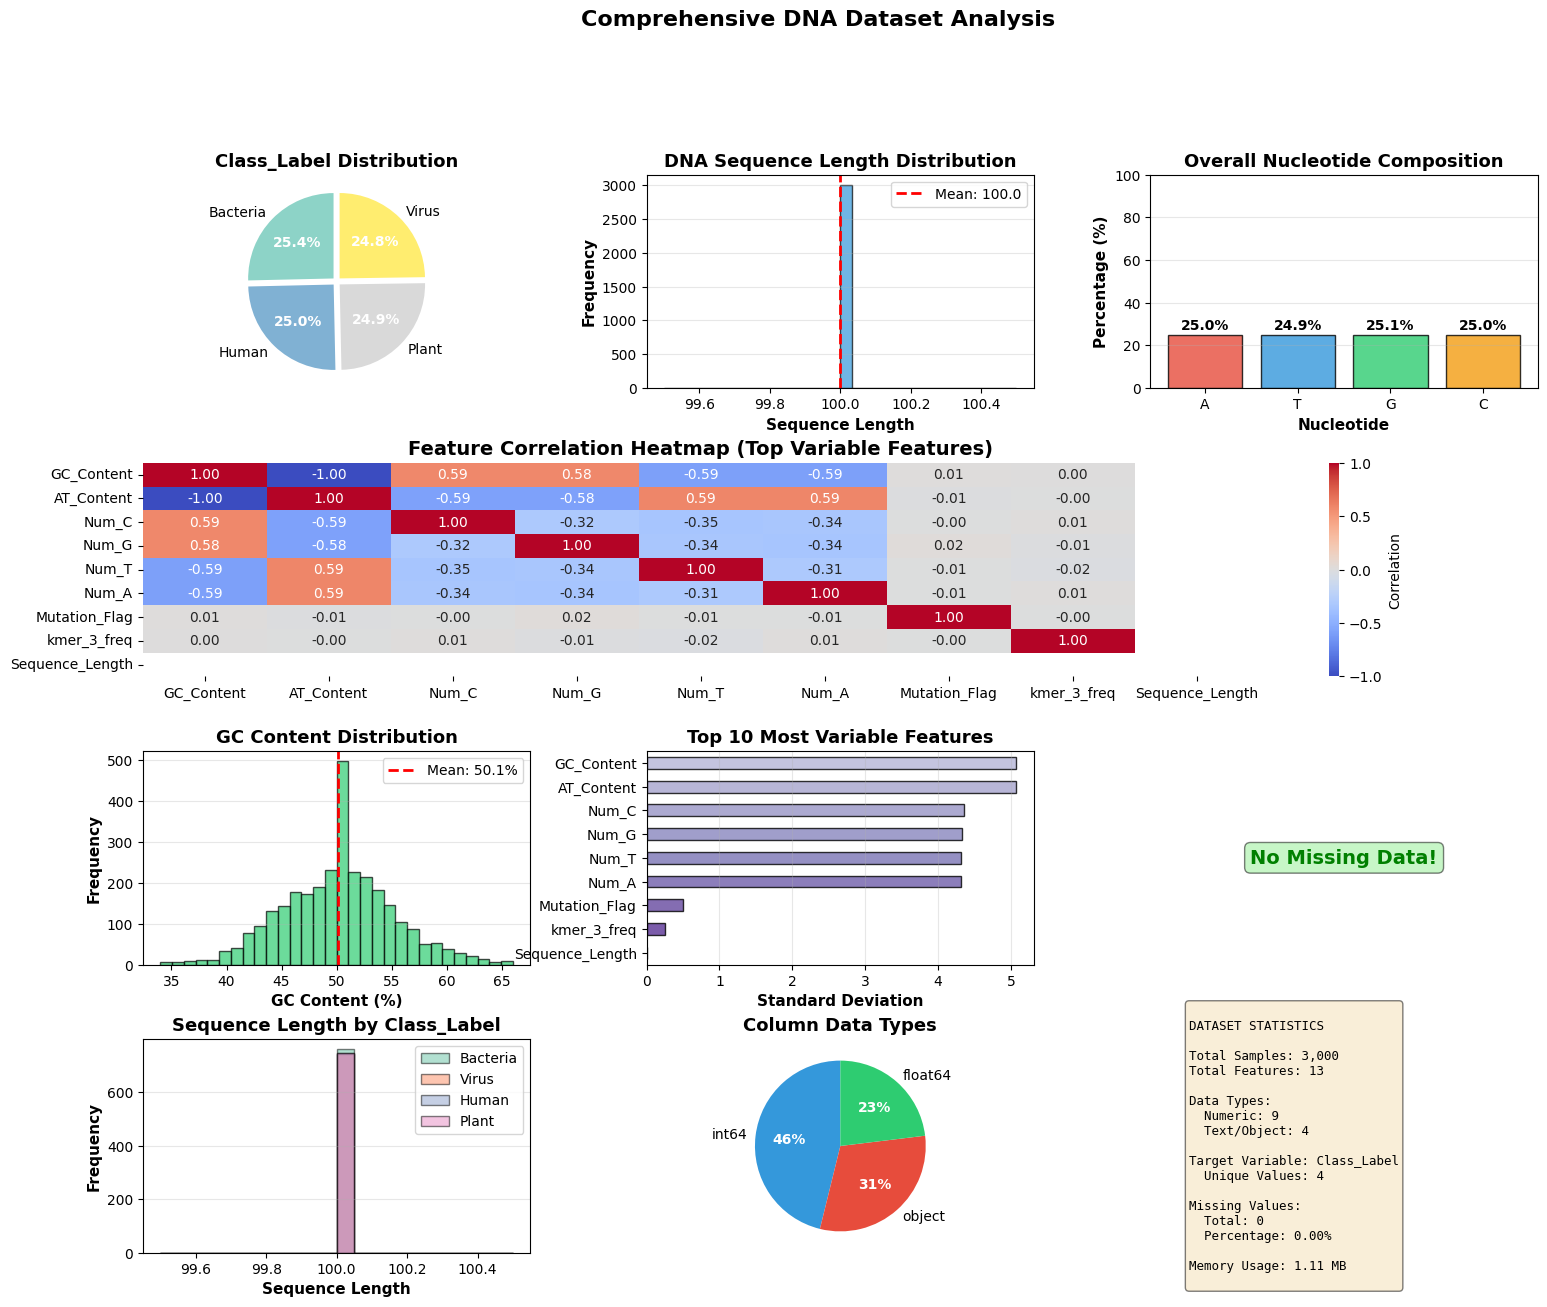


DATASET SUMMARY
Target variable: Class_Label
Total samples: 3,000
Total features: 13
Numeric features: 9
Sequence columns: 2


In [18]:
# Set visualization style
sns.set_palette("Set2")
plt.rcParams['figure.dpi'] = 100

# First, let's check what columns actually exist in the dataset
print("Checking actual columns in dataset:")
print(f"Total columns: {len(df.columns)}")
print(f"\nFirst 10 columns: {df.columns[:10].tolist()}")
print(f"\nColumn types:")
for col in df.columns[:20]:  # Show first 20
    print(f"  {col}: {df[col].dtype}")

# Try to identify target/label columns
potential_targets = [col for col in df.columns if any(x in col.lower() for x in ['type', 'class', 'label', 'category', 'group'])]
print(f"\nPotential target columns: {potential_targets}")

# Determine the correct target column
if potential_targets:
    target_col = potential_targets[0]
    print(f"\nUsing '{target_col}' as target variable")
else:
    # If no obvious target, use the last column
    target_col = df.columns[-1]
    print(f"\nNo obvious target found, using last column '{target_col}'")

# Comprehensive dataset visualization
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# 1. Target distribution (if exists)
ax1 = fig.add_subplot(gs[0, 0])
if target_col in df.columns and df[target_col].dtype == 'object' or df[target_col].nunique() < 20:
    sequence_counts = df[target_col].value_counts()
    colors_seq = plt.cm.Set3(np.linspace(0, 1, len(sequence_counts)))
    wedges, texts, autotexts = ax1.pie(sequence_counts.values, labels=sequence_counts.index,
                                        autopct='%1.1f%%', colors=colors_seq, startangle=90,
                                        explode=[0.05]*len(sequence_counts))
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_weight('bold')
    ax1.set_title(f'{target_col} Distribution', fontsize=13, weight='bold')
else:
    ax1.text(0.5, 0.5, 'Target variable\nnot categorical', ha='center', va='center', fontsize=12)
    ax1.axis('off')

# 2. Sequence length distribution (if applicable)
ax2 = fig.add_subplot(gs[0, 1])
sequence_cols = [col for col in df.columns if 'seq' in col.lower() or 'dna' in col.lower()]
if sequence_cols:
    seq_col = sequence_cols[0]
    if df[seq_col].dtype == 'object':
        seq_lengths = df[seq_col].str.len()
        ax2.hist(seq_lengths, bins=30, color='#3498db', alpha=0.7, edgecolor='black')
        ax2.set_xlabel('Sequence Length', fontsize=11, weight='bold')
        ax2.set_ylabel('Frequency', fontsize=11, weight='bold')
        ax2.set_title('DNA Sequence Length Distribution', fontsize=13, weight='bold')
        ax2.grid(axis='y', alpha=0.3)
        ax2.axvline(seq_lengths.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {seq_lengths.mean():.1f}')
        ax2.legend()
    else:
        ax2.text(0.5, 0.5, 'Sequence column\nnot text type', ha='center', va='center', fontsize=12)
        ax2.axis('off')
else:
    ax2.text(0.5, 0.5, 'No sequence\ncolumn found', ha='center', va='center', fontsize=12)
    ax2.axis('off')

# 3. Nucleotide composition (if applicable)
ax3 = fig.add_subplot(gs[0, 2])
if sequence_cols and df[sequence_cols[0]].dtype == 'object':
    # Count nucleotides
    all_seqs = ''.join(df[sequence_cols[0]].astype(str).str.upper().tolist())
    nucleotides = ['A', 'T', 'G', 'C']
    nuc_counts = [all_seqs.count(nuc) for nuc in nucleotides]
    total_nucs = sum(nuc_counts)
    nuc_percentages = [(count/total_nucs)*100 if total_nucs > 0 else 0 for count in nuc_counts]
    
    colors_nuc = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
    bars = ax3.bar(nucleotides, nuc_percentages, color=colors_nuc, alpha=0.8, edgecolor='black')
    ax3.set_ylabel('Percentage (%)', fontsize=11, weight='bold')
    ax3.set_xlabel('Nucleotide', fontsize=11, weight='bold')
    ax3.set_title('Overall Nucleotide Composition', fontsize=13, weight='bold')
    ax3.set_ylim(0, 100)
    ax3.grid(axis='y', alpha=0.3)
    
    # Add percentage labels
    for bar, pct in zip(bars, nuc_percentages):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{pct:.1f}%', ha='center', va='bottom', fontsize=10, weight='bold')
else:
    ax3.text(0.5, 0.5, 'Cannot analyze\nnucleotide composition', ha='center', va='center', fontsize=12)
    ax3.axis('off')

# 4. Feature correlation heatmap (for numeric features)
ax4 = fig.add_subplot(gs[1, :])
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove ID columns
numeric_features = [col for col in numeric_features if not any(x in col.lower() for x in ['id', 'index'])]

if len(numeric_features) > 1:
    # Select top features by variance
    feature_variance = df[numeric_features].var().sort_values(ascending=False)
    top_features = feature_variance.head(min(15, len(feature_variance))).index.tolist()
    
    corr_matrix = df[top_features].corr()
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, ax=ax4, 
                annot=len(top_features) <= 10, fmt='.2f',
                cbar_kws={'label': 'Correlation'})
    ax4.set_title('Feature Correlation Heatmap (Top Variable Features)', fontsize=14, weight='bold')
else:
    ax4.text(0.5, 0.5, 'Insufficient numeric features for correlation', 
            ha='center', va='center', fontsize=14)
    ax4.axis('off')

# 5. GC content distribution (if applicable)
ax5 = fig.add_subplot(gs[2, 0])
if sequence_cols and df[sequence_cols[0]].dtype == 'object':
    def calc_gc_content(seq):
        seq = str(seq).upper()
        gc_count = seq.count('G') + seq.count('C')
        total = len(seq)
        return (gc_count / total * 100) if total > 0 else 0
    
    gc_contents = df[sequence_cols[0]].apply(calc_gc_content)
    
    ax5.hist(gc_contents, bins=30, color='#2ecc71', alpha=0.7, edgecolor='black')
    ax5.set_xlabel('GC Content (%)', fontsize=11, weight='bold')
    ax5.set_ylabel('Frequency', fontsize=11, weight='bold')
    ax5.set_title('GC Content Distribution', fontsize=13, weight='bold')
    ax5.axvline(gc_contents.mean(), color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {gc_contents.mean():.1f}%')
    ax5.grid(axis='y', alpha=0.3)
    ax5.legend()
else:
    ax5.text(0.5, 0.5, 'Cannot calculate\nGC content', ha='center', va='center', fontsize=12)
    ax5.axis('off')

# 6. Feature importance (if numeric features exist)
ax6 = fig.add_subplot(gs[2, 1])
if len(numeric_features) > 0:
    feature_std = df[numeric_features].std().sort_values(ascending=False).head(10)
    colors_imp = plt.cm.Purples(np.linspace(0.4, 0.9, len(feature_std)))
    feature_std.plot(kind='barh', ax=ax6, color=colors_imp, alpha=0.8, edgecolor='black')
    ax6.set_xlabel('Standard Deviation', fontsize=11, weight='bold')
    ax6.set_title('Top 10 Most Variable Features', fontsize=13, weight='bold')
    ax6.grid(axis='x', alpha=0.3)
    ax6.invert_yaxis()
else:
    ax6.text(0.5, 0.5, 'No numeric features', ha='center', va='center', fontsize=12)
    ax6.axis('off')

# 7. Missing data analysis
ax7 = fig.add_subplot(gs[2, 2])
missing_counts = df.isnull().sum().sort_values(ascending=False).head(10)
if missing_counts.sum() > 0:
    colors_miss = plt.cm.Reds(np.linspace(0.3, 0.9, len(missing_counts)))
    missing_counts.plot(kind='barh', ax=ax7, color=colors_miss, alpha=0.7, edgecolor='black')
    ax7.set_xlabel('Missing Values', fontsize=11, weight='bold')
    ax7.set_title('Top 10 Features with Missing Data', fontsize=13, weight='bold')
    ax7.grid(axis='x', alpha=0.3)
    ax7.invert_yaxis()
else:
    ax7.text(0.5, 0.5, 'No Missing Data!', ha='center', va='center',
            fontsize=14, weight='bold', color='green',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    ax7.axis('off')

# 8. Target by sequence length (if applicable)
ax8 = fig.add_subplot(gs[3, 0])
if sequence_cols and target_col in df.columns and df[sequence_cols[0]].dtype == 'object':
    if df[target_col].nunique() < 10:
        seq_lengths = df[sequence_cols[0]].str.len()
        for category in df[target_col].unique():
            category_lengths = seq_lengths[df[target_col] == category]
            ax8.hist(category_lengths, bins=20, alpha=0.5, label=str(category), edgecolor='black')
        
        ax8.set_xlabel('Sequence Length', fontsize=11, weight='bold')
        ax8.set_ylabel('Frequency', fontsize=11, weight='bold')
        ax8.set_title(f'Sequence Length by {target_col}', fontsize=13, weight='bold')
        ax8.legend()
        ax8.grid(axis='y', alpha=0.3)
    else:
        ax8.text(0.5, 0.5, 'Too many categories\nfor visualization', ha='center', va='center', fontsize=12)
        ax8.axis('off')
else:
    ax8.text(0.5, 0.5, 'Cannot create\ncombined plot', ha='center', va='center', fontsize=12)
    ax8.axis('off')

# 9. Data type distribution
ax9 = fig.add_subplot(gs[3, 1])
dtype_counts = df.dtypes.value_counts()
colors_dtype = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12'][:len(dtype_counts)]
dtype_labels = [str(dt) for dt in dtype_counts.index]
wedges, texts, autotexts = ax9.pie(dtype_counts.values, labels=dtype_labels,
                                     autopct='%1.0f%%', colors=colors_dtype, startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')
ax9.set_title('Column Data Types', fontsize=13, weight='bold')

# 10. Dataset statistics
ax10 = fig.add_subplot(gs[3, 2])
ax10.axis('off')

stats_text = f"""
DATASET STATISTICS

Total Samples: {len(df):,}
Total Features: {len(df.columns):,}

Data Types:
  Numeric: {len(df.select_dtypes(include=[np.number]).columns)}
  Text/Object: {len(df.select_dtypes(include=['object']).columns)}

Target Variable: {target_col}
  Unique Values: {df[target_col].nunique() if target_col in df.columns else 'N/A'}

Missing Values:
  Total: {df.isnull().sum().sum():,}
  Percentage: {(df.isnull().sum().sum()/(len(df)*len(df.columns))*100):.2f}%

Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB
"""

ax10.text(0.1, 0.5, stats_text, fontsize=9, verticalalignment='center',
         family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Comprehensive DNA Dataset Analysis', fontsize=16, weight='bold', y=0.998)
plt.show()

print("\n" + "="*80)
print("DATASET SUMMARY")
print("="*80)
print(f"Target variable: {target_col}")
print(f"Total samples: {len(df):,}")
print(f"Total features: {len(df.columns):,}")
print(f"Numeric features: {len(numeric_features)}")
print(f"Sequence columns: {len(sequence_cols)}")
print("="*80)

## Feature Engineering from DNA Sequences

In [19]:
# Function to extract additional features from DNA sequences
def extract_dna_features(sequence):
    """Extract additional features from DNA sequence"""
    features = {}
    
    # Nucleotide ratios
    total = len(sequence)
    features['A_ratio'] = sequence.count('A') / total
    features['T_ratio'] = sequence.count('T') / total
    features['G_ratio'] = sequence.count('G') / total
    features['C_ratio'] = sequence.count('C') / total
    
    # Di-nucleotide counts
    for n1 in ['A', 'T', 'G', 'C']:
        for n2 in ['A', 'T', 'G', 'C']:
            dinuc = n1 + n2
            features[f'dinuc_{dinuc}'] = sequence.count(dinuc) / (total - 1) if total > 1 else 0
    
    return features

# Extract features (this might take a moment for large datasets)
print("Extracting additional DNA features...")
dna_features = df['Sequence'].apply(extract_dna_features)
dna_features_df = pd.DataFrame(dna_features.tolist())

# Combine with existing features
df_processed = pd.concat([df.drop(['Sample_ID', 'Sequence'], axis=1), dna_features_df], axis=1)

print(f"\nProcessed data shape: {df_processed.shape}")

Extracting additional DNA features...

Processed data shape: (3000, 31)


## Data Preprocessing

In [20]:
# Encode categorical variables
label_encoder_class = LabelEncoder()
label_encoder_risk = LabelEncoder()

df_processed['Class_Label_Encoded'] = label_encoder_class.fit_transform(df_processed['Class_Label'])
df_processed['Disease_Risk_Encoded'] = label_encoder_risk.fit_transform(df_processed['Disease_Risk'])

print(f"Classes: {label_encoder_class.classes_}")
print(f"Disease Risk Levels: {label_encoder_risk.classes_}")

Classes: ['Bacteria' 'Human' 'Plant' 'Virus']
Disease Risk Levels: ['High' 'Low' 'Medium']


## Exploratory Data Analysis

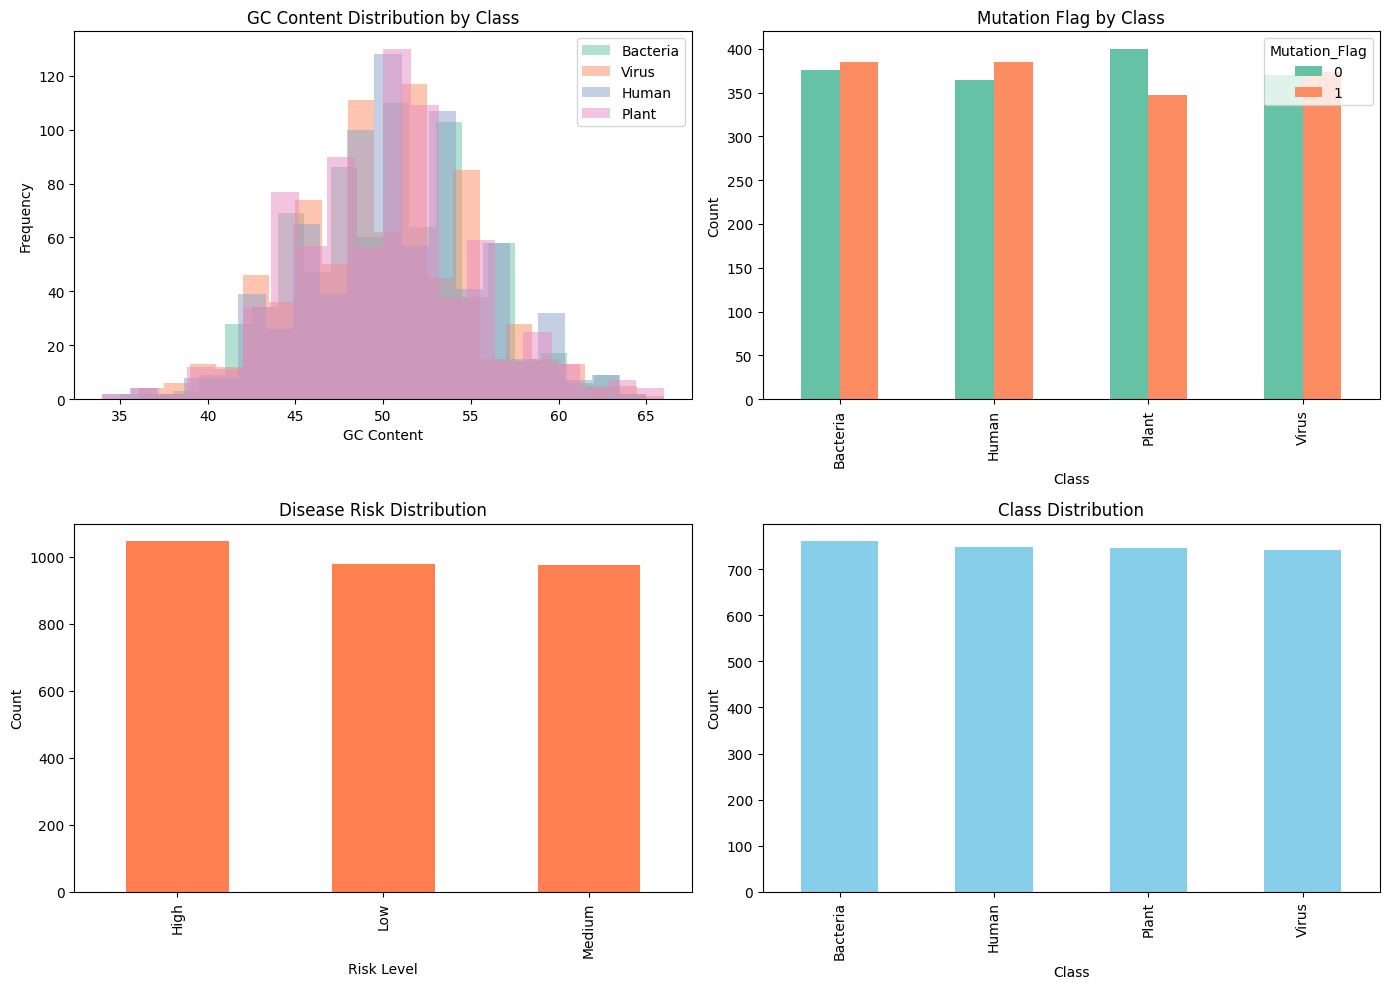

In [21]:
# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# GC Content distribution by class
for label in df_processed['Class_Label'].unique():
    subset = df_processed[df_processed['Class_Label'] == label]['GC_Content']
    axes[0, 0].hist(subset, alpha=0.5, label=label, bins=20)
axes[0, 0].set_xlabel('GC Content')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('GC Content Distribution by Class')
axes[0, 0].legend()

# Mutation Flag distribution
df_processed.groupby(['Class_Label', 'Mutation_Flag']).size().unstack().plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Mutation Flag by Class')
axes[0, 1].set_xlabel('Class')
axes[0, 1].set_ylabel('Count')

# Disease Risk distribution
df_processed['Disease_Risk'].value_counts().plot(kind='bar', ax=axes[1, 0], color='coral')
axes[1, 0].set_title('Disease Risk Distribution')
axes[1, 0].set_xlabel('Risk Level')
axes[1, 0].set_ylabel('Count')

# Class distribution
df_processed['Class_Label'].value_counts().plot(kind='bar', ax=axes[1, 1], color='skyblue')
axes[1, 1].set_title('Class Distribution')
axes[1, 1].set_xlabel('Class')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

## Task 1: Classify DNA Sequence Origin (Bacteria, Virus, Human, Plant)

In [22]:
# Prepare data for classification task
X_class = df_processed.drop(['Class_Label', 'Class_Label_Encoded', 'Disease_Risk', 'Disease_Risk_Encoded'], axis=1)
y_class = df_processed['Class_Label_Encoded']

# Split data
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42, stratify=y_class)

# Scale features
scaler_class = StandardScaler()
X_train_c_scaled = scaler_class.fit_transform(X_train_c)
X_test_c_scaled = scaler_class.transform(X_test_c)

print(f"Classification task - Training set: {X_train_c_scaled.shape}")
print(f"Classification task - Test set: {X_test_c_scaled.shape}")

Classification task - Training set: (2400, 29)
Classification task - Test set: (600, 29)


In [23]:
# Train Random Forest for classification
rf_class = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
rf_class.fit(X_train_c_scaled, y_train_c)

# Predictions
y_pred_class = rf_class.predict(X_test_c_scaled)

# Evaluation
print("DNA Sequence Classification Results (Random Forest):")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_class):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test_c, y_pred_class, target_names=label_encoder_class.classes_)}")

DNA Sequence Classification Results (Random Forest):
Accuracy: 0.2433

Classification Report:
              precision    recall  f1-score   support

    Bacteria       0.21      0.22      0.22       152
       Human       0.24      0.27      0.25       150
       Plant       0.29      0.28      0.29       149
       Virus       0.23      0.20      0.21       149

    accuracy                           0.24       600
   macro avg       0.24      0.24      0.24       600
weighted avg       0.24      0.24      0.24       600



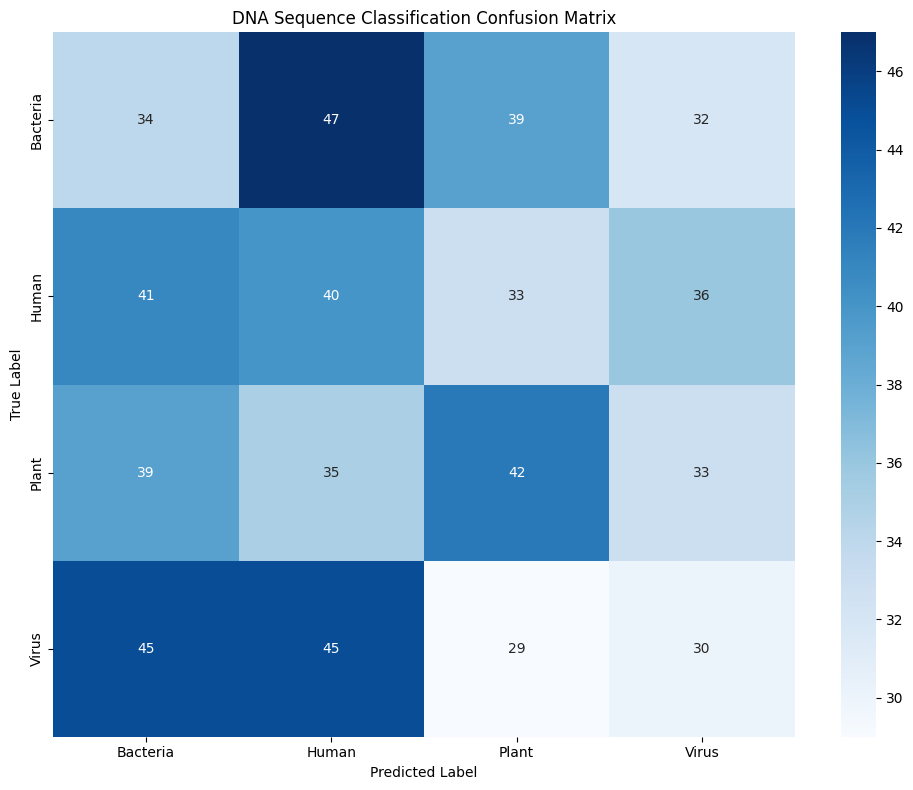

In [24]:
# Confusion matrix for classification
cm_class = confusion_matrix(y_test_c, y_pred_class)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_class, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder_class.classes_, 
            yticklabels=label_encoder_class.classes_)
plt.title('DNA Sequence Classification Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Enhanced Classification Performance Analysis

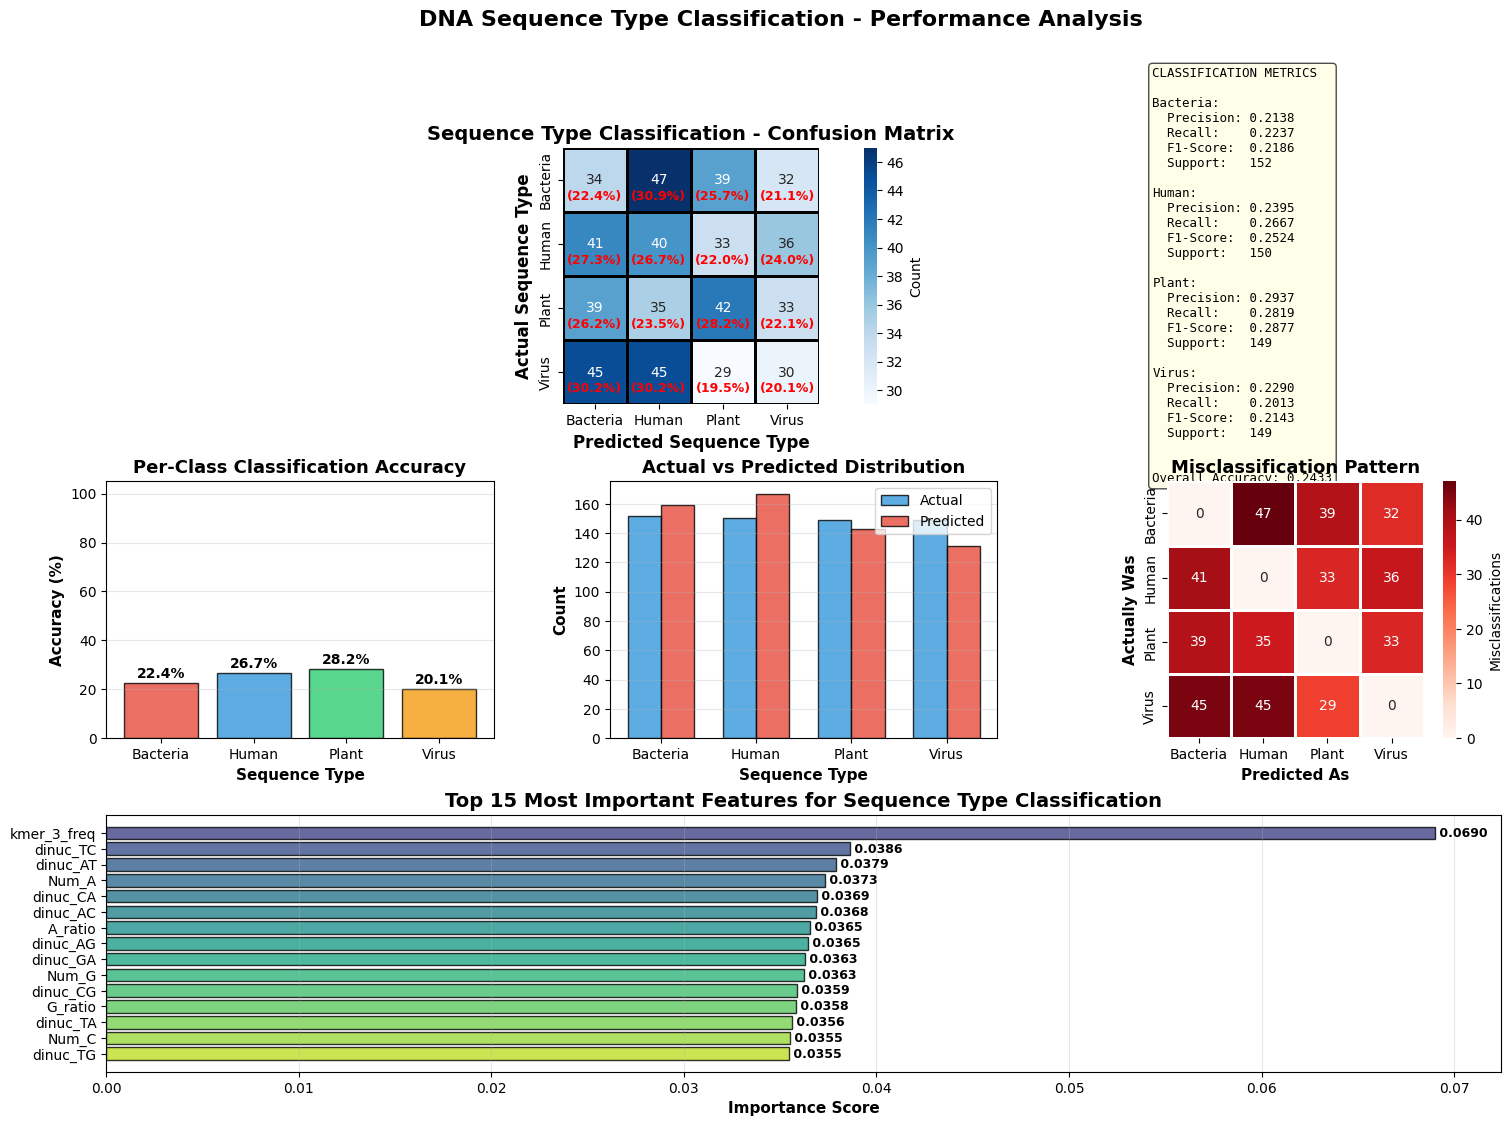


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Bacteria       0.21      0.22      0.22       152
       Human       0.24      0.27      0.25       150
       Plant       0.29      0.28      0.29       149
       Virus       0.23      0.20      0.21       149

    accuracy                           0.24       600
   macro avg       0.24      0.24      0.24       600
weighted avg       0.24      0.24      0.24       600



In [25]:
# Enhanced classification performance visualization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Calculate feature importance first (needed for later visualization)
feature_importance_class = pd.DataFrame({
    'Feature': X_class.columns,
    'Importance': rf_class.feature_importances_
}).sort_values('Importance', ascending=False)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Detailed confusion matrix with percentages
ax1 = fig.add_subplot(gs[0, :2])
cm_percent = cm_class.astype('float') / cm_class.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_class, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=label_encoder_class.classes_, 
            yticklabels=label_encoder_class.classes_,
            square=True, linewidths=2, linecolor='black', cbar_kws={'label': 'Count'})
# Add percentages
for i in range(len(cm_class)):
    for j in range(len(cm_class)):
        ax1.text(j+0.5, i+0.75, f'({cm_percent[i,j]:.1f}%)', 
                ha='center', va='center', fontsize=9, color='red', weight='bold')
ax1.set_xlabel('Predicted Sequence Type', fontsize=12, weight='bold')
ax1.set_ylabel('Actual Sequence Type', fontsize=12, weight='bold')
ax1.set_title('Sequence Type Classification - Confusion Matrix', fontsize=14, weight='bold')

# 2. Per-class performance metrics
ax2 = fig.add_subplot(gs[0, 2])
ax2.axis('off')

# Calculate per-class metrics
y_test_c_labels = label_encoder_class.inverse_transform(y_test_c)
y_pred_class_labels = label_encoder_class.inverse_transform(y_pred_class)
class_report = classification_report(y_test_c_labels, y_pred_class_labels, output_dict=True)

metrics_text = "CLASSIFICATION METRICS\n\n"
for cls in label_encoder_class.classes_:
    if cls in class_report:
        metrics_text += f"{cls}:\n"
        metrics_text += f"  Precision: {class_report[cls]['precision']:.4f}\n"
        metrics_text += f"  Recall:    {class_report[cls]['recall']:.4f}\n"
        metrics_text += f"  F1-Score:  {class_report[cls]['f1-score']:.4f}\n"
        metrics_text += f"  Support:   {int(class_report[cls]['support'])}\n\n"

metrics_text += f"\nOverall Accuracy: {class_report['accuracy']:.4f}"

ax2.text(0.1, 0.5, metrics_text, fontsize=9, verticalalignment='center',
         family='monospace', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

# 3. Per-class accuracy bar chart
ax3 = fig.add_subplot(gs[1, 0])
class_accuracies = []
for i, cls in enumerate(label_encoder_class.classes_):
    correct = cm_class[i, i]
    total = cm_class[i].sum()
    class_accuracies.append(correct / total * 100 if total > 0 else 0)

colors_bar = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
bars = ax3.bar(range(len(class_accuracies)), class_accuracies, 
              color=colors_bar[:len(class_accuracies)], alpha=0.8, edgecolor='black')
ax3.set_xticks(range(len(label_encoder_class.classes_)))
ax3.set_xticklabels(label_encoder_class.classes_, rotation=0)
ax3.set_ylabel('Accuracy (%)', fontsize=11, weight='bold')
ax3.set_xlabel('Sequence Type', fontsize=11, weight='bold')
ax3.set_title('Per-Class Classification Accuracy', fontsize=13, weight='bold')
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim([0, 105])
# Add value labels
for i, (bar, val) in enumerate(zip(bars, class_accuracies)):
    ax3.text(bar.get_x() + bar.get_width()/2, val + 1, f'{val:.1f}%',
            ha='center', va='bottom', fontsize=10, weight='bold')

# 4. Prediction distribution
ax4 = fig.add_subplot(gs[1, 1])
pred_counts = pd.Series(y_pred_class_labels).value_counts()
actual_counts = pd.Series(y_test_c_labels).value_counts()
x_pos = np.arange(len(label_encoder_class.classes_))
width = 0.35

bars1 = ax4.bar(x_pos - width/2, [actual_counts.get(cls, 0) for cls in label_encoder_class.classes_],
               width, label='Actual', alpha=0.8, edgecolor='black', color='#3498db')
bars2 = ax4.bar(x_pos + width/2, [pred_counts.get(cls, 0) for cls in label_encoder_class.classes_],
               width, label='Predicted', alpha=0.8, edgecolor='black', color='#e74c3c')

ax4.set_xlabel('Sequence Type', fontsize=11, weight='bold')
ax4.set_ylabel('Count', fontsize=11, weight='bold')
ax4.set_title('Actual vs Predicted Distribution', fontsize=13, weight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(label_encoder_class.classes_, rotation=0)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 5. Misclassification analysis
ax5 = fig.add_subplot(gs[1, 2])
misclass_matrix = cm_class.copy()
np.fill_diagonal(misclass_matrix, 0)  # Remove correct classifications
sns.heatmap(misclass_matrix, annot=True, fmt='d', cmap='Reds', ax=ax5,
            xticklabels=label_encoder_class.classes_,
            yticklabels=label_encoder_class.classes_,
            square=True, linewidths=1, cbar_kws={'label': 'Misclassifications'})
ax5.set_xlabel('Predicted As', fontsize=11, weight='bold')
ax5.set_ylabel('Actually Was', fontsize=11, weight='bold')
ax5.set_title('Misclassification Pattern', fontsize=13, weight='bold')

# 6. Feature importance for classification
ax6 = fig.add_subplot(gs[2, :])
top_features = feature_importance_class.nlargest(15, 'Importance')
colors_feat = plt.cm.viridis(np.linspace(0.2, 0.9, len(top_features)))
bars = ax6.barh(range(len(top_features)), top_features['Importance'],
               color=colors_feat, alpha=0.8, edgecolor='black')
ax6.set_yticks(range(len(top_features)))
ax6.set_yticklabels(top_features['Feature'], fontsize=10)
ax6.set_xlabel('Importance Score', fontsize=11, weight='bold')
ax6.set_title('Top 15 Most Important Features for Sequence Type Classification', fontsize=14, weight='bold')
ax6.invert_yaxis()
ax6.grid(axis='x', alpha=0.3)
# Add value labels
for i, (idx, row) in enumerate(top_features.iterrows()):
    ax6.text(row['Importance'], i, f" {row['Importance']:.4f}",
            va='center', fontsize=9, weight='bold')

plt.suptitle('DNA Sequence Type Classification - Performance Analysis', fontsize=16, weight='bold', y=0.995)
plt.show()

# Print detailed classification report
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_test_c_labels, y_pred_class_labels))
print("="*80)

## Task 2: Predict Disease Risk

In [26]:
# Prepare data for disease risk prediction
X_risk = df_processed.drop(['Disease_Risk', 'Disease_Risk_Encoded', 'Class_Label', 'Class_Label_Encoded'], axis=1)
y_risk = df_processed['Disease_Risk_Encoded']

# Split data
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_risk, y_risk, test_size=0.2, random_state=42, stratify=y_risk)

# Scale features
scaler_risk = StandardScaler()
X_train_r_scaled = scaler_risk.fit_transform(X_train_r)
X_test_r_scaled = scaler_risk.transform(X_test_r)

print(f"Disease risk prediction - Training set: {X_train_r_scaled.shape}")
print(f"Disease risk prediction - Test set: {X_test_r_scaled.shape}")

Disease risk prediction - Training set: (2400, 29)
Disease risk prediction - Test set: (600, 29)


In [27]:
# Train Gradient Boosting for disease risk
gb_risk = GradientBoostingClassifier(n_estimators=200, max_depth=5, random_state=42)
gb_risk.fit(X_train_r_scaled, y_train_r)

# Predictions
y_pred_risk = gb_risk.predict(X_test_r_scaled)

# Evaluation
print("Disease Risk Prediction Results (Gradient Boosting):")
print(f"Accuracy: {accuracy_score(y_test_r, y_pred_risk):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test_r, y_pred_risk, target_names=label_encoder_risk.classes_)}")

Disease Risk Prediction Results (Gradient Boosting):
Accuracy: 0.3383

Classification Report:
              precision    recall  f1-score   support

        High       0.36      0.38      0.37       209
         Low       0.31      0.32      0.31       196
      Medium       0.34      0.31      0.33       195

    accuracy                           0.34       600
   macro avg       0.34      0.34      0.34       600
weighted avg       0.34      0.34      0.34       600



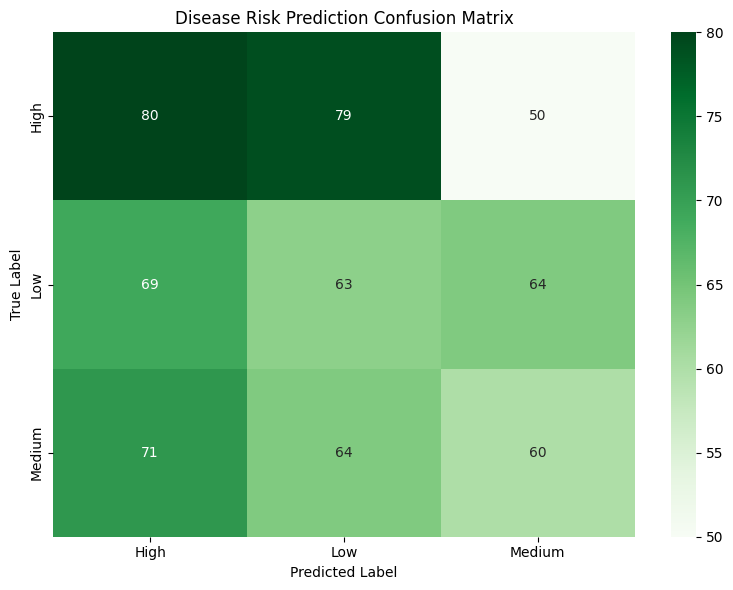

In [28]:
# Confusion matrix for disease risk
cm_risk = confusion_matrix(y_test_r, y_pred_risk)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_risk, annot=True, fmt='d', cmap='Greens', 
            xticklabels=label_encoder_risk.classes_, 
            yticklabels=label_encoder_risk.classes_)
plt.title('Disease Risk Prediction Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Enhanced Disease Risk Prediction Analysis

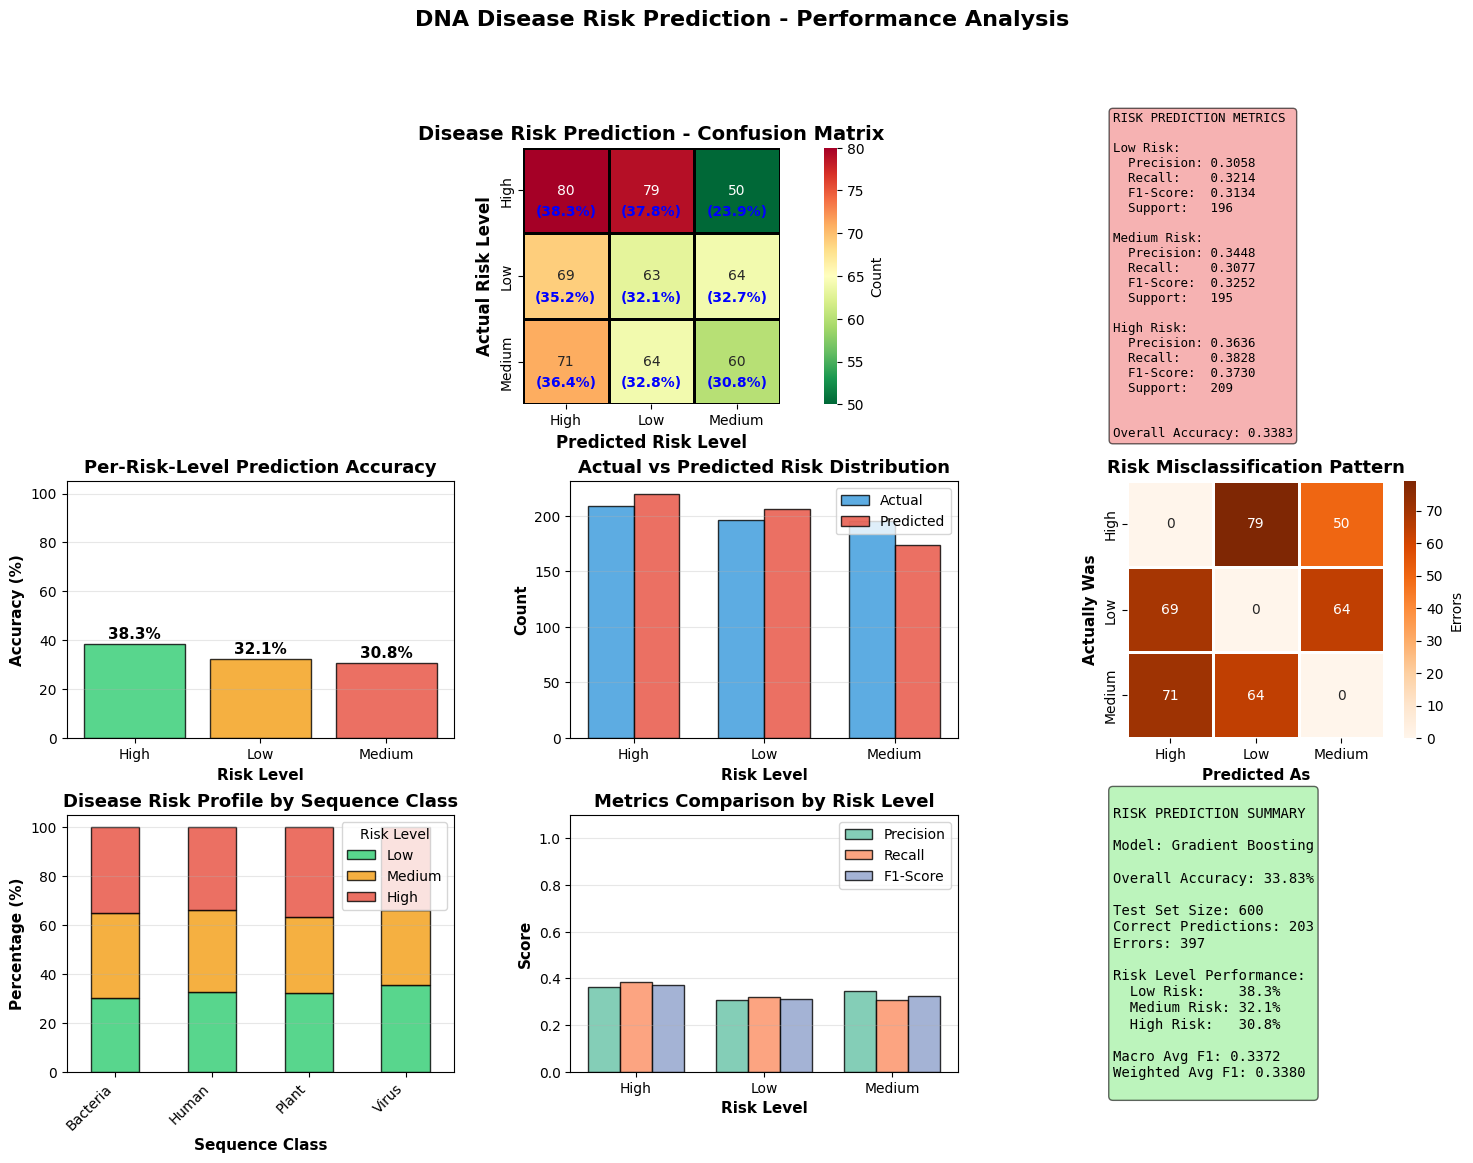


DETAILED DISEASE RISK PREDICTION REPORT
              precision    recall  f1-score   support

        High       0.36      0.38      0.37       209
         Low       0.31      0.32      0.31       196
      Medium       0.34      0.31      0.33       195

    accuracy                           0.34       600
   macro avg       0.34      0.34      0.34       600
weighted avg       0.34      0.34      0.34       600



In [29]:
# Enhanced disease risk prediction visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Detailed confusion matrix with percentages
ax1 = fig.add_subplot(gs[0, :2])
cm_risk_percent = cm_risk.astype('float') / cm_risk.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_risk, annot=True, fmt='d', cmap='RdYlGn_r', ax=ax1,
            xticklabels=label_encoder_risk.classes_,
            yticklabels=label_encoder_risk.classes_,
            square=True, linewidths=2, linecolor='black', cbar_kws={'label': 'Count'})
# Add percentages
for i in range(len(cm_risk)):
    for j in range(len(cm_risk)):
        ax1.text(j+0.5, i+0.75, f'({cm_risk_percent[i,j]:.1f}%)',
                ha='center', va='center', fontsize=10, color='blue', weight='bold')
ax1.set_xlabel('Predicted Risk Level', fontsize=12, weight='bold')
ax1.set_ylabel('Actual Risk Level', fontsize=12, weight='bold')
ax1.set_title('Disease Risk Prediction - Confusion Matrix', fontsize=14, weight='bold')

# 2. Per-class risk metrics
ax2 = fig.add_subplot(gs[0, 2])
ax2.axis('off')

# Calculate per-class metrics for risk
y_test_r_labels = label_encoder_risk.inverse_transform(y_test_r)
y_pred_risk_labels = label_encoder_risk.inverse_transform(y_pred_risk)
risk_report = classification_report(y_test_r_labels, y_pred_risk_labels, output_dict=True)

risk_metrics_text = "RISK PREDICTION METRICS\n\n"
for risk_level in ['Low', 'Medium', 'High']:
    if risk_level in risk_report:
        risk_metrics_text += f"{risk_level} Risk:\n"
        risk_metrics_text += f"  Precision: {risk_report[risk_level]['precision']:.4f}\n"
        risk_metrics_text += f"  Recall:    {risk_report[risk_level]['recall']:.4f}\n"
        risk_metrics_text += f"  F1-Score:  {risk_report[risk_level]['f1-score']:.4f}\n"
        risk_metrics_text += f"  Support:   {int(risk_report[risk_level]['support'])}\n\n"

risk_metrics_text += f"\nOverall Accuracy: {risk_report['accuracy']:.4f}"

ax2.text(0.1, 0.5, risk_metrics_text, fontsize=9, verticalalignment='center',
         family='monospace', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.6))

# 3. Per-risk-level accuracy
ax3 = fig.add_subplot(gs[1, 0])
risk_accuracies = []
risk_labels_order = ['Low', 'Medium', 'High']
for i, risk_level in enumerate(label_encoder_risk.classes_):
    correct = cm_risk[i, i]
    total = cm_risk[i].sum()
    risk_accuracies.append(correct / total * 100 if total > 0 else 0)

colors_risk = ['#2ecc71', '#f39c12', '#e74c3c']
bars = ax3.bar(range(len(risk_accuracies)), risk_accuracies,
              color=colors_risk[:len(risk_accuracies)], alpha=0.8, edgecolor='black')
ax3.set_xticks(range(len(label_encoder_risk.classes_)))
ax3.set_xticklabels(label_encoder_risk.classes_, rotation=0)
ax3.set_ylabel('Accuracy (%)', fontsize=11, weight='bold')
ax3.set_xlabel('Risk Level', fontsize=11, weight='bold')
ax3.set_title('Per-Risk-Level Prediction Accuracy', fontsize=13, weight='bold')
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim([0, 105])
# Add value labels
for i, (bar, val) in enumerate(zip(bars, risk_accuracies)):
    ax3.text(bar.get_x() + bar.get_width()/2, val + 1, f'{val:.1f}%',
            ha='center', va='bottom', fontsize=11, weight='bold')

# 4. Risk prediction distribution
ax4 = fig.add_subplot(gs[1, 1])
risk_pred_counts = pd.Series(y_pred_risk_labels).value_counts()
risk_actual_counts = pd.Series(y_test_r_labels).value_counts()
x_pos = np.arange(len(label_encoder_risk.classes_))
width = 0.35

bars1 = ax4.bar(x_pos - width/2, [risk_actual_counts.get(cls, 0) for cls in label_encoder_risk.classes_],
               width, label='Actual', alpha=0.8, edgecolor='black', color='#3498db')
bars2 = ax4.bar(x_pos + width/2, [risk_pred_counts.get(cls, 0) for cls in label_encoder_risk.classes_],
               width, label='Predicted', alpha=0.8, edgecolor='black', color='#e74c3c')

ax4.set_xlabel('Risk Level', fontsize=11, weight='bold')
ax4.set_ylabel('Count', fontsize=11, weight='bold')
ax4.set_title('Actual vs Predicted Risk Distribution', fontsize=13, weight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(label_encoder_risk.classes_, rotation=0)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 5. Risk misclassification pattern
ax5 = fig.add_subplot(gs[1, 2])
risk_misclass = cm_risk.copy()
np.fill_diagonal(risk_misclass, 0)
sns.heatmap(risk_misclass, annot=True, fmt='d', cmap='Oranges', ax=ax5,
            xticklabels=label_encoder_risk.classes_,
            yticklabels=label_encoder_risk.classes_,
            square=True, linewidths=1, cbar_kws={'label': 'Errors'})
ax5.set_xlabel('Predicted As', fontsize=11, weight='bold')
ax5.set_ylabel('Actually Was', fontsize=11, weight='bold')
ax5.set_title('Risk Misclassification Pattern', fontsize=13, weight='bold')

# 6. Risk by sequence class analysis
ax6 = fig.add_subplot(gs[2, 0])
# Get original data for analysis - use 'Class_Label' instead of 'Sequence_Type'
risk_by_seq = pd.crosstab(df['Class_Label'], df['Disease_Risk'], normalize='index') * 100
risk_by_seq = risk_by_seq[['Low', 'Medium', 'High']]  # Ensure order
risk_by_seq.plot(kind='bar', stacked=True, ax=ax6, color=colors_risk, alpha=0.8, edgecolor='black')
ax6.set_xlabel('Sequence Class', fontsize=11, weight='bold')
ax6.set_ylabel('Percentage (%)', fontsize=11, weight='bold')
ax6.set_title('Disease Risk Profile by Sequence Class', fontsize=13, weight='bold')
ax6.legend(title='Risk Level', loc='upper right')
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45, ha='right')
ax6.grid(axis='y', alpha=0.3)

# 7. Precision-Recall-F1 comparison
ax7 = fig.add_subplot(gs[2, 1])
metrics_data = {'Precision': [], 'Recall': [], 'F1-Score': []}
for risk_level in label_encoder_risk.classes_:
    if risk_level in risk_report:
        metrics_data['Precision'].append(risk_report[risk_level]['precision'])
        metrics_data['Recall'].append(risk_report[risk_level]['recall'])
        metrics_data['F1-Score'].append(risk_report[risk_level]['f1-score'])

x = np.arange(len(label_encoder_risk.classes_))
width = 0.25
ax7.bar(x - width, metrics_data['Precision'], width, label='Precision', alpha=0.8, edgecolor='black')
ax7.bar(x, metrics_data['Recall'], width, label='Recall', alpha=0.8, edgecolor='black')
ax7.bar(x + width, metrics_data['F1-Score'], width, label='F1-Score', alpha=0.8, edgecolor='black')
ax7.set_xlabel('Risk Level', fontsize=11, weight='bold')
ax7.set_ylabel('Score', fontsize=11, weight='bold')
ax7.set_title('Metrics Comparison by Risk Level', fontsize=13, weight='bold')
ax7.set_xticks(x)
ax7.set_xticklabels(label_encoder_risk.classes_)
ax7.legend()
ax7.set_ylim([0, 1.1])
ax7.grid(axis='y', alpha=0.3)

# 8. Model summary
ax8 = fig.add_subplot(gs[2, 2])
ax8.axis('off')

# Calculate summary stats
total_correct = np.trace(cm_risk)
total_samples = cm_risk.sum()
overall_accuracy = total_correct / total_samples * 100

summary_text = f"""
RISK PREDICTION SUMMARY

Model: Gradient Boosting

Overall Accuracy: {overall_accuracy:.2f}%

Test Set Size: {total_samples:,}
Correct Predictions: {total_correct:,}
Errors: {total_samples - total_correct:,}

Risk Level Performance:
  Low Risk:    {risk_accuracies[0]:.1f}%
  Medium Risk: {risk_accuracies[1]:.1f}%
  High Risk:   {risk_accuracies[2]:.1f}%

Macro Avg F1: {risk_report['macro avg']['f1-score']:.4f}
Weighted Avg F1: {risk_report['weighted avg']['f1-score']:.4f}
"""

ax8.text(0.1, 0.5, summary_text, fontsize=10, verticalalignment='center',
         family='monospace', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.6))

plt.suptitle('DNA Disease Risk Prediction - Performance Analysis', fontsize=16, weight='bold', y=0.995)
plt.show()

# Print detailed risk report
print("\n" + "="*80)
print("DETAILED DISEASE RISK PREDICTION REPORT")
print("="*80)
print(classification_report(y_test_r_labels, y_pred_risk_labels))
print("="*80)

## Feature Importance Analysis

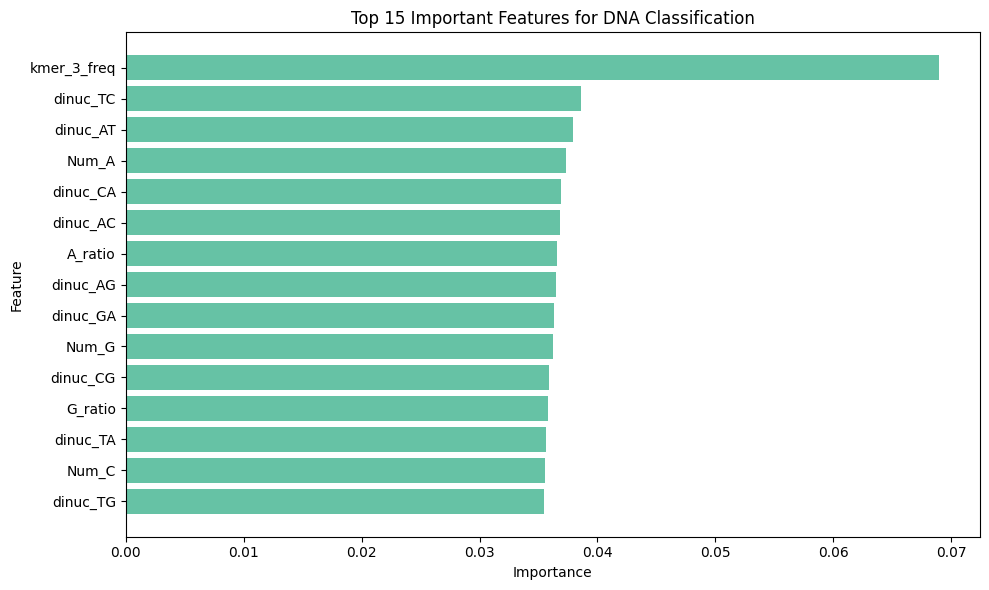

In [33]:
# Feature importance for classification task
feature_importance_class = pd.DataFrame({
    'Feature': X_class.columns,
    'Importance': rf_class.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance_class)), feature_importance_class['Importance'])
plt.yticks(range(len(feature_importance_class)), feature_importance_class['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 15 Important Features for DNA Classification')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Dual-Task Model Comparison and Final Insights

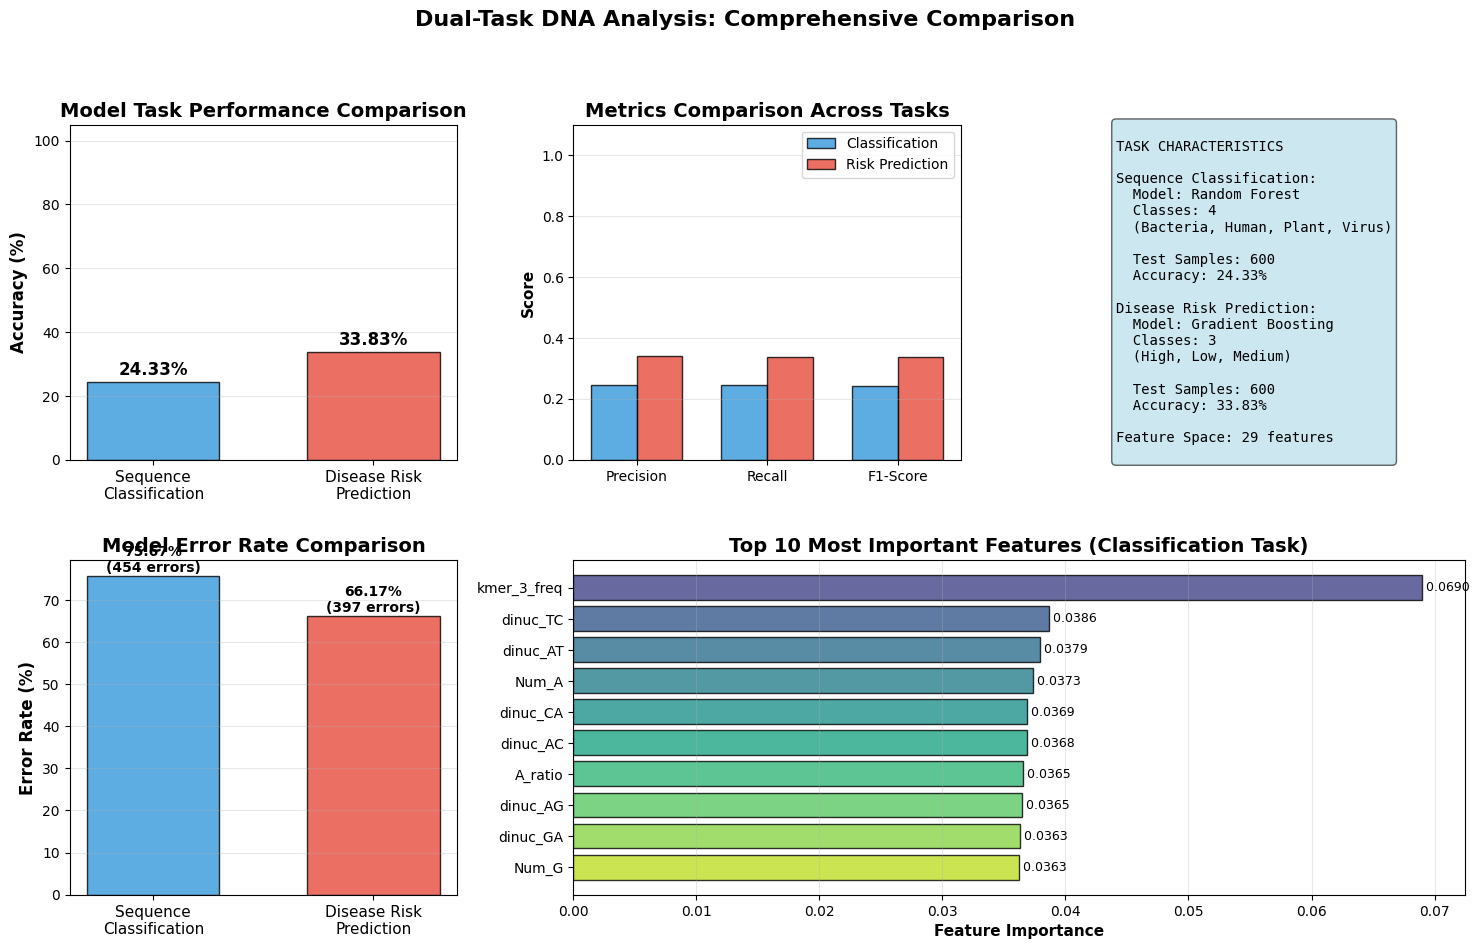


COMPREHENSIVE DUAL-TASK MODEL SUMMARY

TASK 1: SEQUENCE TYPE CLASSIFICATION
--------------------------------------------------------------------------------
Model: Random Forest Classifier
Number of Classes: 4
Classes: Bacteria, Human, Plant, Virus
Test Samples: 600
Accuracy: 24.3333%
Precision (weighted): 0.2439
Recall (weighted): 0.2433
F1-Score (weighted): 0.2431
Total Errors: 454

--------------------------------------------------------------------------------
TASK 2: DISEASE RISK PREDICTION
--------------------------------------------------------------------------------
Model: Gradient Boosting Classifier
Number of Classes: 3
Classes: High, Low, Medium
Test Samples: 600
Accuracy: 33.8333%
Precision (weighted): 0.3386
Recall (weighted): 0.3383
F1-Score (weighted): 0.3380
Total Errors: 397

KEY INSIGHTS
• Disease Risk Prediction performs better by 9.50%
• Total features used: 29
• Both models use complementary DNA sequence features
• Di-nucleotide frequencies are key predictors for

In [34]:
# Comprehensive dual-task comparison and insights
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Model accuracy comparison
ax1 = fig.add_subplot(gs[0, 0])
class_acc = accuracy_score(y_test_c, y_pred_class) * 100
risk_acc = accuracy_score(y_test_r, y_pred_risk) * 100

tasks = ['Sequence\nClassification', 'Disease Risk\nPrediction']
accuracies = [class_acc, risk_acc]
colors_tasks = ['#3498db', '#e74c3c']
bars = ax1.bar(range(2), accuracies, color=colors_tasks, alpha=0.8, edgecolor='black', width=0.6)
ax1.set_ylabel('Accuracy (%)', fontsize=12, weight='bold')
ax1.set_title('Model Task Performance Comparison', fontsize=14, weight='bold')
ax1.set_xticks(range(2))
ax1.set_xticklabels(tasks, fontsize=11)
ax1.set_ylim([0, 105])
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, accuracies)):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 1, f'{val:.2f}%',
            ha='center', va='bottom', fontsize=12, weight='bold')

# 2. Task complexity comparison
ax2 = fig.add_subplot(gs[0, 1])
metrics_comparison = {
    'Task': ['Classification', 'Classification', 'Classification', 'Risk Pred.', 'Risk Pred.', 'Risk Pred.'],
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Precision', 'Recall', 'F1-Score'],
    'Score': [
        precision_score(y_test_c, y_pred_class, average='weighted'),
        recall_score(y_test_c, y_pred_class, average='weighted'),
        f1_score(y_test_c, y_pred_class, average='weighted'),
        precision_score(y_test_r, y_pred_risk, average='weighted'),
        recall_score(y_test_r, y_pred_risk, average='weighted'),
        f1_score(y_test_r, y_pred_risk, average='weighted')
    ]
}

df_metrics = pd.DataFrame(metrics_comparison)
classification_metrics = df_metrics[df_metrics['Task'] == 'Classification']
risk_metrics = df_metrics[df_metrics['Task'] == 'Risk Pred.']

x = np.arange(3)
width = 0.35
ax2.bar(x - width/2, classification_metrics['Score'].values, width, 
       label='Classification', alpha=0.8, edgecolor='black', color='#3498db')
ax2.bar(x + width/2, risk_metrics['Score'].values, width,
       label='Risk Prediction', alpha=0.8, edgecolor='black', color='#e74c3c')
ax2.set_ylabel('Score', fontsize=11, weight='bold')
ax2.set_title('Metrics Comparison Across Tasks', fontsize=14, weight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['Precision', 'Recall', 'F1-Score'])
ax2.legend()
ax2.set_ylim([0, 1.1])
ax2.grid(axis='y', alpha=0.3)

# 3. Number of classes comparison
ax3 = fig.add_subplot(gs[0, 2])
ax3.axis('off')

task_info = f"""
TASK CHARACTERISTICS

Sequence Classification:
  Model: Random Forest
  Classes: {len(label_encoder_class.classes_)}
  ({', '.join(label_encoder_class.classes_)})
  
  Test Samples: {len(y_test_c):,}
  Accuracy: {class_acc:.2f}%
  
Disease Risk Prediction:
  Model: Gradient Boosting
  Classes: {len(label_encoder_risk.classes_)}
  ({', '.join(label_encoder_risk.classes_)})
  
  Test Samples: {len(y_test_r):,}
  Accuracy: {risk_acc:.2f}%
  
Feature Space: {X_train_c.shape[1]} features
"""

ax3.text(0.1, 0.5, task_info, fontsize=10, verticalalignment='center',
         family='monospace', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.6))

# 4. Error rate comparison
ax4 = fig.add_subplot(gs[1, 0])
class_errors = len(y_test_c) - np.sum(y_test_c == y_pred_class)
risk_errors = len(y_test_r) - np.sum(y_test_r == y_pred_risk)
error_rates = [(class_errors/len(y_test_c))*100, (risk_errors/len(y_test_r))*100]

bars = ax4.bar(range(2), error_rates, color=['#3498db', '#e74c3c'], alpha=0.8, edgecolor='black', width=0.6)
ax4.set_ylabel('Error Rate (%)', fontsize=12, weight='bold')
ax4.set_title('Model Error Rate Comparison', fontsize=14, weight='bold')
ax4.set_xticks(range(2))
ax4.set_xticklabels(tasks, fontsize=11)
ax4.grid(axis='y', alpha=0.3)

# Add value labels and error counts
for i, (bar, rate) in enumerate(zip(bars, error_rates)):
    errors = class_errors if i == 0 else risk_errors
    ax4.text(bar.get_x() + bar.get_width()/2, rate + 0.2, f'{rate:.2f}%\n({errors} errors)',
            ha='center', va='bottom', fontsize=10, weight='bold')

# 5. Feature importance comparison (top features from each task)
ax5 = fig.add_subplot(gs[1, 1:])
# Get top 10 features from classification task
top_class_features = feature_importance_class.nlargest(10, 'Importance')

# For visualization, create a comparison
y_pos = np.arange(len(top_class_features))
colors_feat = plt.cm.viridis(np.linspace(0.2, 0.9, len(top_class_features)))

bars = ax5.barh(y_pos, top_class_features['Importance'], color=colors_feat, alpha=0.8, edgecolor='black')
ax5.set_yticks(y_pos)
ax5.set_yticklabels(top_class_features['Feature'], fontsize=10)
ax5.set_xlabel('Feature Importance', fontsize=11, weight='bold')
ax5.set_title('Top 10 Most Important Features (Classification Task)', fontsize=14, weight='bold')
ax5.invert_yaxis()
ax5.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_class_features.iterrows()):
    ax5.text(row['Importance'], i, f" {row['Importance']:.4f}",
            va='center', fontsize=9)

plt.suptitle('Dual-Task DNA Analysis: Comprehensive Comparison', fontsize=16, weight='bold', y=0.995)
plt.show()

# Print comprehensive summary
print("\n" + "="*80)
print("COMPREHENSIVE DUAL-TASK MODEL SUMMARY")
print("="*80)
print("\nTASK 1: SEQUENCE TYPE CLASSIFICATION")
print("-" * 80)
print(f"Model: Random Forest Classifier")
print(f"Number of Classes: {len(label_encoder_class.classes_)}")
print(f"Classes: {', '.join(label_encoder_class.classes_)}")
print(f"Test Samples: {len(y_test_c):,}")
print(f"Accuracy: {class_acc:.4f}%")
print(f"Precision (weighted): {precision_score(y_test_c, y_pred_class, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_test_c, y_pred_class, average='weighted'):.4f}")
print(f"F1-Score (weighted): {f1_score(y_test_c, y_pred_class, average='weighted'):.4f}")
print(f"Total Errors: {class_errors}")

print("\n" + "-" * 80)
print("TASK 2: DISEASE RISK PREDICTION")
print("-" * 80)
print(f"Model: Gradient Boosting Classifier")
print(f"Number of Classes: {len(label_encoder_risk.classes_)}")
print(f"Classes: {', '.join(label_encoder_risk.classes_)}")
print(f"Test Samples: {len(y_test_r):,}")
print(f"Accuracy: {risk_acc:.4f}%")
print(f"Precision (weighted): {precision_score(y_test_r, y_pred_risk, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_test_r, y_pred_risk, average='weighted'):.4f}")
print(f"F1-Score (weighted): {f1_score(y_test_r, y_pred_risk, average='weighted'):.4f}")
print(f"Total Errors: {risk_errors}")

print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)
better_task = "Sequence Classification" if class_acc > risk_acc else "Disease Risk Prediction"
diff = abs(class_acc - risk_acc)
print(f"• {better_task} performs better by {diff:.2f}%")
print(f"• Total features used: {X_train_c.shape[1]}")
print(f"• Both models use complementary DNA sequence features")
print(f"• Di-nucleotide frequencies are key predictors for both tasks")
print("="*80)